In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
from sklearn.datasets import fetch_mldata
import time
%matplotlib inline  
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import skimage.io as io
import skimage.transform as transform
from sklearn import metrics
from skimage import filters
from skimage.transform import SimilarityTransform
import random

#import 

In [2]:
def euclidean_distance(X, Y):
    return np.sqrt(np.abs((X ** 2).sum(axis=1).reshape(-1, 1) +
                   (Y ** 2).sum(axis=1) - 2 * np.dot(X, Y.T)))

def cosine_distance(X, Y):
    return 1 - np.dot(X, Y.T) / np.sqrt((X
            ** 2).sum(axis=1)).reshape(-1, 1) / np.sqrt((Y
            ** 2).sum(axis=1))

In [3]:
class KNNClassifier:
    def __init__(self, k, strategy, metric,
                 weights, test_block_size):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
        if self.strategy != 'my_own':
            self.knn_classifier = NearestNeighbors(n_neighbors = self.k, 
                                                   algorithm=self.strategy, 
                                                   metric = self.metric)
        self.eps = 1e-5
    
    def fit(self, X, y):
        self.y = np.copy(y).astype(int)
        if self.strategy != 'my_own':
            self.knn_classifier.fit(X, y)
        else:
            self.X = np.copy(X).astype(float)

            
    def find_kneighbors(self, X, return_distance):
        test = np.copy(X)
        if self.strategy != 'my_own':
            dist, idx = self.knn_classifier.kneighbors(test, n_neighbors = self.k)
            dist = dist.reshape(-1, self.k)
            idx = idx.reshape(-1, self.k)
        else:
            if self.metric == 'euclidean':
                d = euclidean_distance(test, self.X)
            else:
                d = cosine_distance(test, self.X)
            d1 = np.copy(d)
            dist = np.sort(d, axis = 1)[:, :self.k]
            idx = np.argsort(d1, axis = 1)[:, :self.k]
        if return_distance:
            return (dist, idx.astype(int))
        else:
            return idx.astype(int)
    
    def predict(self, X):
        self.eps = 1e-5
        pred = np.zeros(0).astype(int)
        for i in range(0, X.shape[0], self.test_block_size):
            test = np.copy(X[i : i + self.test_block_size])
            
            if not self.weights:
                idx = self.find_kneighbors(test, return_distance = False)
                classes = self.y[idx]
                p = np.array([np.bincount(classes[i]).argmax() for i in range(classes.shape[0])]).astype(int)
                pred = np.hstack((pred, p))
            else:
                dist, idx = self.find_kneighbors(test, return_distance = True)
                w = 1 / (dist + self.eps)
                classes = self.y[idx]
                p = np.array([np.bincount(classes[i], w[i]).argmax() for i in range(classes.shape[0])]).astype(int)
                pred = np.hstack((pred, p))
            
        return pred  


In [4]:
def kfold(n, n_folds):
    folds = []
    size = n // n_folds
    pos_valid = 0 
    for i in range(n_folds):
        if (i >= n % n_folds):
            valid = np.arange(pos_valid, pos_valid + size)
            train = np.arange(0, pos_valid)
            train = np.hstack((train, np.arange(pos_valid + size, n)))
            pos_valid = pos_valid + size
        else:
            valid = np.arange(pos_valid, pos_valid + size + 1)
            train = np.arange(0, pos_valid)
            train = np.hstack((train, np.arange(pos_valid + size + 1, n)))
            pos_valid = pos_valid+ size + 1
        folds.append((train, valid))
    return folds

def knn_cross_val_score(X, y, k_list, score, cv, **kwargs):
    if cv == None:
        cv = kfold(X.shape[0], 3)
    if score == 'accuracy':
        m = KNNClassifier(max(k_list), **kwargs)
        sc = {}
        
        for fold in cv:
            train = fold[0]
            valid = fold[1]
            x_val = X[valid]
            y_val = y[valid].astype(int)
            y_train = y[train].astype(int)

            m.fit(X[train], y_train)
            if not kwargs['weights']:
                idx = m.find_kneighbors(x_val, return_distance = False)
                w = np.ones((idx.shape[0], idx.shape[1]))
            else:
                dist, idx = m.find_kneighbors(x_val, return_distance = True)
                w = 1 / (dist + 1e-5)

            classes = y_train[idx]
            for k in k_list:
                p = np.array([np.bincount(classes[i][:k], w[i][:k]).argmax()
                             for i in range(classes.shape[0])]).astype(int)
                if k in sc:
                    sc[k] = np.hstack((sc[k], np.array(np.mean(y_val == p))))
                else:
                    sc[k] = np.array([np.mean(y_val == p)])
        return sc
    
def cross_val_clock(X, y, **kwargs):
    m = KNNClassifier(**kwargs)
    t1 = time.perf_counter()
    cv = kfold(X.shape[0], 3)
    for i, fold in enumerate(cv):
        train = fold[0]
        valid = fold[1]
        x_val = X[valid]
        y_train = y[train].astype(int)
        m.fit(X[train], y[train])
        p = m.predict(x_val)
    t2 = time.perf_counter()
    return t2 - t1

In [5]:
mnist = fetch_mldata('MNIST original')
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]
X_test = mnist.data[60000:]
y_test = mnist.target[60000:]


5 ближ соседей в обуч выборке для евклидовой метрики
10, 20, 100 признаков случайно

In [8]:
k = [10, 20, 100]
strategy = ['my_own', 'brute', 'kd_tree', 'ball_tree']
models_time = [[], [], [], []]

for j, cnt_f in enumerate(k):
    print(j)
    idx_f = np.arange(0, X_train.shape[1])
    np.random.shuffle(idx_f)
    idx_f = idx_f[:cnt_f]
    for i, strat in enumerate(strategy):
        print(i)
        m = KNNClassifier(5, strat, 'euclidean', False, 1024)
        m.fit(X_train[:, idx_f], y_train)
        t1 = time.perf_counter()
        m.find_kneighbors(X_test[:,idx_f], False)
        t2 = time.perf_counter()
        models_time[i].append(t2 - t1)
    

0
0
1
2
3
1
0
1
2
3
2
0
1
2
3


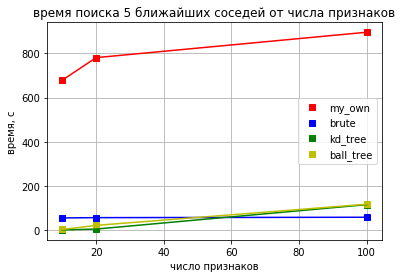

In [9]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.plot(k, models_time[0], 'rs', k, models_time[1], 'bs', k, models_time[2], 'gs', k, models_time[3], 'ys')

ax.plot(k, models_time[0], 'r', k, models_time[1], 'b', k, models_time[2], 'g', k, models_time[3], 'y')
ax.set_xlabel('число признаков')
ax.set_ylabel('время, с')
ax.set_title("время поиска 5 ближайших соседей от числа признаков")
ax.legend(strategy)
ax.grid()


In [12]:
fig.savefig("f.pdf")

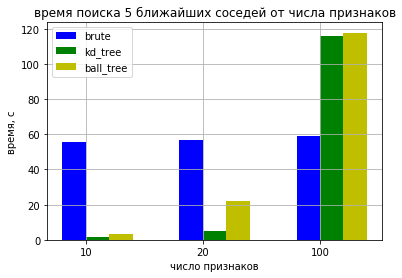

In [13]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.bar(np.arange(3), models_time[1], width = 0.2, color = 'b')
ax.bar(np.arange(3)+0.2, models_time[2], width = 0.2, color = 'g')
ax.bar(np.arange(3)+0.4, models_time[3], width = 0.2, color = 'y')

ax.set_xlabel('число признаков')
ax.set_ylabel('время, с')
ax.set_title("время поиска 5 ближайших соседей от числа признаков")
ax.legend(strategy[1:])
plt.xticks([0.1, 1.1, 2.1], [10, 20, 100])
ax.grid()

fig.savefig("f1.pdf")

3 фолда, точность (к от 1 до 10 + МЕТРИКА) на кросс валидации и время работы от метрики

In [14]:
mnist = fetch_mldata('MNIST original')
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X = np.hstack((X_train, y_train.reshape(-1, 1)))
np.random.shuffle(X)
X_train = X[:, :784]
y_train = X[:, 784:]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]
y_train = y_train.reshape(60000,)


In [80]:
k = np.arange(1, 11).astype(int)

euclidean_accuracy = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                    cv = None, strategy = 'brute', metric = 'euclidean',  
                    weights = False, test_block_size = 1024)
print(1)

1


In [82]:
cosine_accuracy = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                    cv = None, strategy = 'brute', metric = 'cosine',  
                    weights = False, test_block_size = 1024)

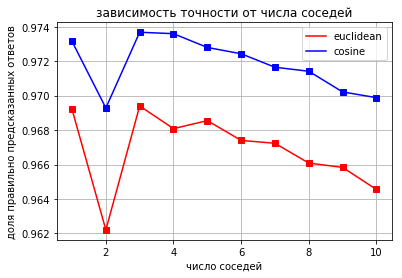

In [86]:
metric = ['euclidean', 'cosine']
euc = [np.mean(i[1]) for i in euclidean_accuracy.items()]
cos = [np.mean(i[1]) for i in cosine_accuracy.items()]
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.plot(k, euc, 'r', k, cos, 'b')
ax.plot(k, euc, 'rs', k, cos, 'bs')
ax.set_xlabel('число соседей')
ax.set_ylabel('доля правильно предсказанных ответов')
ax.set_title("зависимость точности от числа соседей")
ax.legend(metric)

ax.grid()

fig.savefig("fig1.pdf")

In [32]:
euc_time =  cross_val_clock(X_train, y_train, k = 10, strategy = 'brute', 
                            metric = 'euclidean', weights = False, 
                            test_block_size = 1024)

In [34]:
cos_time = cross_val_clock(X_train, y_train, k = 10, 
                    strategy = 'brute', metric = 'cosine',  
                    weights = False, test_block_size = 1024)

In [33]:
euc_time

119.25340989999995

In [35]:
cos_time

148.17294420000007

([<matplotlib.axis.XTick at 0x21980d19cf8>,
 <a list of 2 Text xticklabel objects>)

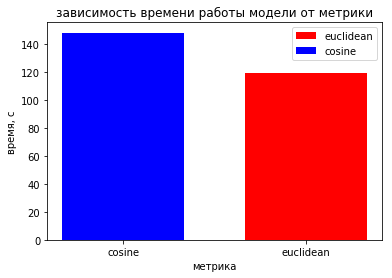

In [38]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.bar(np.arange(1), [euc_time], 0.2, color = 'r')
ax.bar(np.arange(1) - 0.3, [cos_time], width = 0.2, color = 'b')

ax.set_xlabel('метрика')
ax.set_ylabel('время, с')
ax.set_title("зависимость времени работы модели от метрики")
ax.legend(['euclidean', 'cosine'])
plt.xticks([-0.3, 0.0], ['cosine', 'euclidean'])


In [24]:
fig.savefig("fig2_1.pdf")

In [ ]:
k = np.arange(1, 11).astype(int)

euclidean_accuracy_w = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                    cv = None, strategy = 'brute', metric = 'euclidean',  
                    weights = True, test_block_size = 1024)
print(1)
cosine_accuracy_w = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                    cv = None, strategy = 'brute', metric = 'cosine',  
                    weights = True, test_block_size = 1024)
print(2)

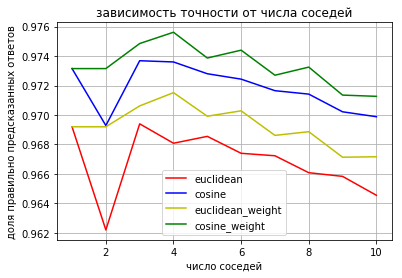

In [101]:
metric = ['euclidean', 'cosine', 'euclidean_weight', 'cosine_weight']
euc_w = [np.mean(i[1]) for i in euclidean_accuracy_w.items()]
cos_w = [np.mean(i[1]) for i in cosine_accuracy_w.items()]
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.plot(k, euc, 'r', k, cos, 'b', k, euc_w, 'y', k, cos_w, 'g')
#ax.plot(k, euc_w, 'rs', k, cos_w, 'bs')
ax.set_xlabel('число соседей')
ax.set_ylabel('доля правильно предсказанных ответов')
ax.set_title("зависимость точности от числа соседей")
ax.legend(metric)

ax.grid()

fig.savefig("fig3.pdf")

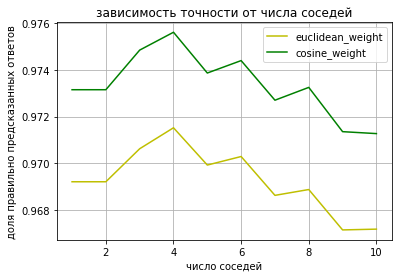

In [102]:
metric = ['euclidean_weight', 'cosine_weight']
euc_w = [np.mean(i[1]) for i in euclidean_accuracy_w.items()]
cos_w = [np.mean(i[1]) for i in cosine_accuracy_w.items()]
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.plot(k, euc_w, 'y', k, cos_w, 'g')
#ax.plot(k, euc_w, 'rs', k, cos_w, 'bs')
ax.set_xlabel('число соседей')
ax.set_ylabel('доля правильно предсказанных ответов')
ax.set_title("зависимость точности от числа соседей")
ax.legend(metric)

ax.grid()

fig.savefig("fig44.pdf")

In [ ]:
k = np.arange(1, 11).astype(int)

euc_time_w =  cross_val_clock(X_train, y_train, k = 10, strategy = 'brute', 
                            metric = 'euclidean', weights = True, 
                            test_block_size = 1024)
print(1)

In [36]:
cos_time_w = cross_val_clock(X_train, y_train, k = 10, strategy = 'brute', 
                            metric = 'cosine', weights = True, 
                            test_block_size = 1024)

In [26]:
euc_time_w

128.9846315000001

In [37]:
cos_time_w

161.9320227000003

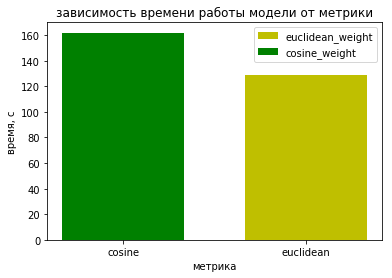

In [39]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.bar(np.arange(1), [euc_time_w], 0.2, color = 'y')
ax.bar(np.arange(1) - 0.3, [cos_time_w], width = 0.2, color = 'g')

ax.set_xlabel('метрика')
ax.set_ylabel('время, с')
ax.set_title("зависимость времени работы модели от метрики")
ax.legend(['euclidean_weight', 'cosine_weight'])
plt.xticks([-0.3, 0.0], ['cosine', 'euclidean'])
fig.savefig("fig5.pdf")

([<matplotlib.axis.XTick at 0x21980dee208>,
 <a list of 4 Text xticklabel objects>)

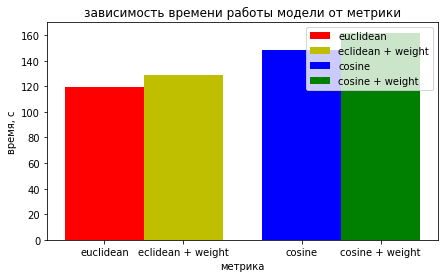

In [40]:
fig = plt.figure(figsize=(7, 4))
ax = plt.subplot(111)
ax.bar(np.arange(1) - 0.2, [euc_time], width = 0.2, color = 'r')
ax.bar(np.arange(1), [euc_time_w], width = 0.2, color = 'y')
ax.bar(np.arange(1) + 0.3, [cos_time], width = 0.2, color = 'b')
ax.bar(np.arange(1) + 0.5, [cos_time_w], width = 0.2, color = 'g')


ax.set_xlabel('метрика')
ax.set_ylabel('время, с')
ax.set_title("зависимость времени работы модели от метрики")
ax.legend(['euclidean', 'eclidean + weight', 'cosine', 'cosine + weight'])
plt.xticks([-0.2, 0.0, 0.3, 0.5], ['euclidean', 'eclidean + weight', 'cosine', 'cosine + weight'])


In [41]:
fig.savefig("fig6.png")

4 - лучший алгоритм: brute cosine weight

In [117]:
mnist = fetch_mldata('MNIST original')
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]
X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

In [118]:
k_list = np.arange(1, 11)
score = []
for k in k_list:
    m = KNNClassifier(k, 'brute', 'cosine', True, 1024)
    m.fit(X_train, y_train)
    res = m.predict(X_test)
    score.append(np.mean(y_test == res))


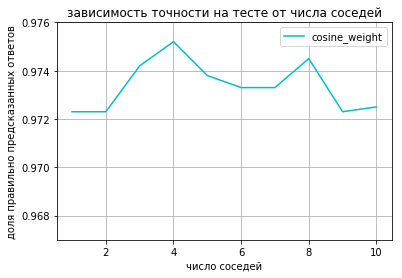

In [127]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

ax.plot(k_list, score, 'c')
ax.set_xlabel('число соседей')
ax.set_ylabel('доля правильно предсказанных ответов')
ax.set_title("зависимость точности на тесте от числа соседей")
ax.grid()
ax.legend(['cosine_weight'])
ax.set_ylim(0.967, 0.976)
plt.yticks(np.arange(0.968, 0.977, 0.002))

fig.savefig("figure.pdf")

Лучшие результаты https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

In [79]:
from sklearn import metrics

In [80]:
m = KNNClassifier(4, 'brute', 'cosine', True, 1024)
m.fit(X_train, y_train)
res = m.predict(X_test)


np.mean(y_test == res)

0.9752

In [83]:
mist = metrics.confusion_matrix(y_test, res)
mist

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]],
      dtype=int64)

By definition, entry $(i, j)$ in a confusion matrix is the number of observations actually in group $i$, but predicted to be in group $j$

Основные ошибки $(4 -> 9)$; $(3 -> 5)$; $(7 -> 1)$; $(7->9)$

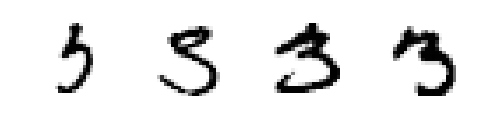

In [153]:
X = X_test[(y_test == 3) & (res == 5)][[6, 0, 11, 3]]
fig, axs = plt.subplots(figsize=(8, 10), ncols = 4)
for i in range(X.shape[0]):
    axs[i].imshow(X[i].reshape(-1, 28),  cmap = 'Greys')
    axs[i].axis("off")


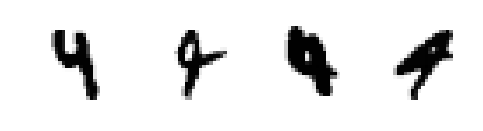

In [162]:
X = X_test[(y_test == 4) & (res == 9)][[4, 16, 23, 1]]
fig, axs = plt.subplots(figsize=(8, 5), ncols = 4)
for i in range(X.shape[0]):
    axs[i].imshow(X[i].reshape(-1, 28), cmap = 'Greys')
    axs[i].axis("off")

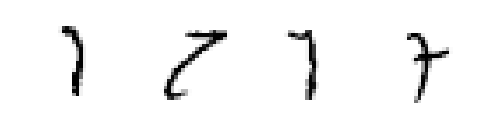

In [166]:
X = X_test[(y_test == 7) & (res == 1)][[1, 4, 6, 9]]
fig, axs = plt.subplots(figsize=(8, 5), ncols = 4)
for i in range(X.shape[0]):
    axs[i].imshow(X[i].reshape(-1, 28), cmap = 'Greys')
    axs[i].axis("off")

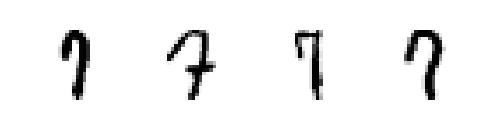

In [170]:
X = X_test[(y_test == 7) & (res == 9)][[6, 12, 0, 9]]
fig, axs = plt.subplots(figsize=(8, 5), ncols = 4)
for i in range(X.shape[0]):
    axs[i].imshow(X[i].reshape(-1, 28), cmap = 'Greys')
    axs[i].axis("off")

Ошибки связаны с изменением наклона, слиянием частей цифры, недорисованными линиями

Эксперимент 5 - Размножение выборки

In [10]:
changes = {'rotate', 'shift_lr', 'shift_ud', 'gauss'}
rot = [0, 5, 10, 15]
shift = [0, 1, 2, 3]
gauss = [0, 0.5, 1, 1.5]


In [11]:
def change_im(X_train, name, v):
    X = np.copy(X_train)
    
    if name == 'gauss':
        res = np.empty((X.shape[0] * 2, X.shape[1]))
        res[0:X.shape[0]] = np.copy(X_train)
        pos = X.shape[0]
        for im in X:
            res[pos] = filters.gaussian(im.reshape(-1, 28), v).reshape(1, -1)
            pos += 1
            
    if name == 'rotate':
        res = np.empty((X.shape[0] * 3, X.shape[1]))
        res[0:X.shape[0]] = np.copy(X_train)
        pos = X.shape[0]
        for im in X:
            res[pos] = transform.rotate(im.reshape(-1, 28), v).reshape(1, -1)
            pos += 1     
        for im in X:
            res[pos] = transform.rotate(im.reshape(-1, 28), -v).reshape(1, -1)
            pos += 1  
            
    if name == 'shift':
        res = np.empty((X.shape[0] * 5, X.shape[1]))
        res[0:X.shape[0]] = np.copy(X_train)
        pos = X.shape[0]
        for im in X:
            tform = SimilarityTransform(translation=(0, v))
            res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
            pos += 1  
        for im in X:
            tform = SimilarityTransform(translation=(0, -v))
            res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
            pos += 1  
        for im in X:
            tform = SimilarityTransform(translation=(v, 0))
            res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
            pos += 1  
        for im in X:
            tform = SimilarityTransform(translation=(-v, 0))
            res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
            pos += 1  
           
    return res
            
        

In [12]:
def cross_val(X_t, y_t, k=4, **kwargs):
    
    iters = 100
    size = X_t.shape[0] * 2 // iters // 3 
    
    cv = kfold(X_t.shape[0], 3)
    m = KNNClassifier(k, **kwargs)
    
    sc = []
    pred = []

    for fold in cv:
        distance = np.empty((X_t.shape[0] // 3, k * iters))
        classes = np.empty((X_t.shape[0] // 3, k * iters))        
            
        train = fold[0]
        valid = fold[1]
        x_val = X_t[valid]
        y_val = y_t[valid].astype(int)
        y_train = y_t[train].astype(int)
        x_train = X_t[train]
        
    
        for i in range(iters):
            X = x_train[i * size: i * size + size, :]
            y = y_train[i * size: i * size + size]
            m.fit(X, y)
            dist, idx = m.find_kneighbors(x_val, return_distance=True)
            distance[:, i * k : i * k + k] = dist
            classes[:, i * k : i * k + k] = y[idx]
        
        d1 = np.copy(distance)
        dist = (np.sort(distance, axis=1))[:, :k]
        cl = (np.argsort(d1, axis = 1))[:, :k]
        classes = np.array([classes[i][j] for i, j  in enumerate(cl)]).astype(int)

        classes = classes[:, :k]
        w = 1/(dist + 1e-5)
            
            
        p = np.array([np.bincount(classes[i], w[i]).argmax()
                     for i in range(classes.shape[0])]).astype(int)

        sc.append(([np.mean(y_val == p)]))
        pred.append(p)
    return sc, pred

In [13]:
def cross_val_pred(X_t, y_t, x_val, y_val, k=4, **kwargs):
    
    iters = 100
    size = X_t.shape[0] // iters
    
    m = KNNClassifier(k, **kwargs)

    distance = np.empty((x_val.shape[0], k * iters))
    classes = np.empty((x_val.shape[0], k * iters))        

    y_train = y_t.astype(int)
    x_train = X_t

    for i in range(iters):
        if  i % 10 == 0:
            print (i)
        X = x_train[i * size: i * size + size, :]
        y = y_train[i * size: i * size + size]
        m.fit(X, y)
        dist, idx = m.find_kneighbors(x_val, return_distance=True)
        distance[:, i * k : i * k + k] = dist
        classes[:, i * k : i * k + k] = y[idx]

    d1 = np.copy(distance)
    dist = (np.sort(distance, axis=1))[:, :k]
    cl = (np.argsort(d1, axis = 1))[:, :k]
    classes = np.array([classes[i][j] for i, j  in enumerate(cl)]).astype(int)

    classes = classes[:, :k]
    w = 1/(dist + 1e-5)

    p = np.array([np.bincount(classes[i], w[i]).argmax()
                 for i in range(classes.shape[0])]).astype(int)

    return np.mean(y_val == p), p

In [14]:
mnist = fetch_mldata('MNIST original')
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X = np.hstack((X_train, y_train.reshape(-1, 1)))
np.random.shuffle(X)
X_train = X[:, :784]
y_train = X[:, 784:]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]
y_train = y_train.reshape(60000,)



подбор параметров по  кросс-валидации в ноутбуке exp5!

In [38]:
X = change_im(X_train, 'shift', 1)
y = np.copy(y_train)
for i in range(4):
    y = np.concatenate((y, y_train))
print(1)

m = KNNClassifier(4, 'brute', 'cosine', True, 256)
m.fit(X, y)
print(2)
res = m.predict(X_test)

1
2


In [39]:
np.mean(res == y_test)

0.9798

In [40]:
res_shift = np.copy(res)

In [42]:
mist_shift = metrics.confusion_matrix(y_test, res)
mist_shift

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1132,    3,    0,    0,    0,    0,    0,    0,    0],
       [   8,    0, 1011,    1,    0,    0,    2,    9,    1,    0],
       [   1,    0,    1,  988,    0,    7,    0,    5,    6,    2],
       [   1,    1,    0,    0,  951,    0,    5,    0,    1,   23],
       [   3,    0,    0,   10,    1,  861,    6,    2,    6,    3],
       [   3,    2,    0,    0,    0,    2,  951,    0,    0,    0],
       [   2,    8,    4,    0,    2,    0,    0, 1002,    0,   10],
       [   3,    0,    2,    6,    1,    4,    5,    4,  945,    4],
       [   6,    6,    1,    3,    4,    3,    0,    4,    2,  980]],
      dtype=int64)

In [49]:
X = change_im(X_train, 'rotate', 10)
y = np.copy(y_train)
for i in range(2):
    y = np.concatenate((y, y_train))
print(1)

m = KNNClassifier(4, 'brute', 'cosine', True, 256)
m.fit(X, y)
print(2)
res = m.predict(X_test)

1
2


In [50]:
np.mean(res == y_test)

0.9813

In [52]:
res_rot_10= np.copy(res)
mist_rot_10 = metrics.confusion_matrix(y_test, res)
mist_rot_10

array([[ 976,    1,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    0,    1,    0,    0],
       [   6,    2, 1008,    2,    1,    0,    1,   10,    2,    0],
       [   0,    0,    1,  986,    1,    7,    0,    3,    7,    5],
       [   1,    0,    0,    0,  952,    0,    5,    2,    0,   22],
       [   3,    0,    0,    6,    1,  874,    3,    2,    1,    2],
       [   2,    3,    0,    0,    0,    1,  951,    0,    1,    0],
       [   2,    7,    3,    0,    0,    0,    0, 1008,    0,    8],
       [   2,    0,    3,    5,    4,    3,    2,    3,  947,    5],
       [   4,    4,    1,    5,    5,    2,    1,    5,    3,  979]],
      dtype=int64)

In [61]:
X = change_im(X_train, 'gauss', 1)
y = np.copy(y_train)
for i in range(1):
    y = np.concatenate((y, y_train))
print(1)

m = KNNClassifier(4, 'brute', 'cosine', True, 256)
m.fit(X, y)
print(2)
res = m.predict(X_test)

1
2


In [62]:
np.mean(res == y_test)

0.9813

In [63]:
res_gauss1 = np.copy(res)
mist_gauss1 = metrics.confusion_matrix(y_test, res)
mist_gauss1

array([[ 977,    1,    0,    0,    0,    0,    0,    2,    0,    0],
       [   0, 1130,    3,    0,    0,    0,    2,    0,    0,    0],
       [   7,    1, 1006,    2,    1,    0,    1,   12,    2,    0],
       [   0,    0,    1,  986,    1,    9,    0,    4,    5,    4],
       [   0,    0,    0,    0,  960,    0,    4,    3,    0,   15],
       [   2,    1,    0,    6,    1,  872,    4,    1,    2,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   0,    7,    6,    0,    3,    1,    0, 1003,    0,    8],
       [   3,    0,    1,    3,    3,    3,    3,    4,  951,    3],
       [   2,    4,    0,    2,    8,    3,    1,    7,    2,  980]],
      dtype=int64)

In [9]:

def change_im_rand_best(X_train):
    rot = [-15, -10,-5, 5, 10, 15]
    shift = [-3, -2, -1, 1, 2, 3]
    gauss = [1, 1.5, 0.5]
    X = np.copy(X_train)
    
    a = random.randint(1, 3)
    res = np.empty((X.shape[0] * 4, X.shape[1]))
    res[0:X.shape[0]] = np.copy(X_train)
    pos = X.shape[0]
    
    for i in range(3):
        for im in X:
            if a == 1: #gauss
                b = random.randint(0, 1)
                res[pos] = filters.gaussian(im.reshape(-1, 28), gauss[b]).reshape(1, -1)
                pos += 1

            if a == 2: #rotate
                b = random.randint(0, 3)
                res[pos] = transform.rotate(im.reshape(-1, 28), rot[b]).reshape(1, -1)
                pos += 1     

            if a == 3: #shift
                b = random.randint(0, 5)
                c = random.randint(0, 5)
                d = random.randint(0, 1)
                if d == 0:
                    b = 0
                else:
                    c = 0
                tform = SimilarityTransform(translation=(shift[b], shift[c]))
                res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
                pos += 1  
           
    return res
            
        

In [66]:
X = change_im_rand_best(X_train)
y = np.copy(y_train)
for i in range(3):
    y = np.concatenate((y, y_train))
print(1)

m = KNNClassifier(4, 'brute', 'cosine', True, 256)
m.fit(X, y)
print(2)
res = m.predict(X_test)

1
2


In [67]:
np.mean(res == y_test)

0.9787

In [68]:
res_rand = np.copy(res)
mist_rand = metrics.confusion_matrix(y_test, res)
mist_rand

array([[ 975,    1,    0,    0,    0,    1,    1,    1,    1,    0],
       [   0, 1131,    2,    0,    0,    1,    1,    0,    0,    0],
       [   6,    2, 1006,    3,    1,    0,    1,   11,    2,    0],
       [   0,    0,    1,  983,    1,   10,    0,    5,    5,    5],
       [   0,    0,    0,    0,  957,    0,    4,    3,    1,   17],
       [   1,    2,    0,    9,    1,  868,    5,    1,    2,    3],
       [   3,    3,    0,    0,    1,    3,  947,    0,    1,    0],
       [   0,    7,    4,    2,    4,    0,    1, 1000,    0,   10],
       [   2,    0,    5,    7,    3,    5,    5,    3,  940,    4],
       [   2,    4,    0,    1,   10,    4,    0,    6,    2,  980]],
      dtype=int64)

In [97]:

def change_im_all(X_train):
    rot = [-10, 10]
    shift = [-1,0, 1]
    gauss = [1]
    X = np.copy(X_train)
    
    res = np.empty((X.shape[0] * 8, X.shape[1]))
    res[0:X.shape[0]] = np.copy(X_train)
    pos = X.shape[0]
    
    for im in X:
        res[pos] = filters.gaussian(im.reshape(-1, 28), 1).reshape(1, -1)
        pos += 1
            
    for im in X:
        res[pos] = transform.rotate(im.reshape(-1, 28), -10).reshape(1, -1)
        pos += 1
    for im in X:
        res[pos] = transform.rotate(im.reshape(-1, 28), 10).reshape(1, -1)
        pos += 1

        
    for im in X:
        tform = SimilarityTransform(translation=(0, 1))
        res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
        pos += 1  
    for im in X:
        tform = SimilarityTransform(translation=(1, 0))
        res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
        pos += 1 
    for im in X:
        tform = SimilarityTransform(translation=(-1, 0))
        res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
        pos += 1             
    for im in X:
        tform = SimilarityTransform(translation=(0, -1))
        res[pos] = transform.warp(im.reshape(-1, 28), tform).reshape(1, -1)
        pos += 1 
           
    return res
            
        

In [98]:
X = change_im_all(X_train)
y = np.copy(y_train)
for i in range(7):
    y = np.concatenate((y, y_train))
print(1)

m = KNNClassifier(4, 'brute', 'cosine', True, 128)
m.fit(X, y)
print(2)
res = m.predict(X_test)

1
2


In [99]:
np.mean(res == y_test)

0.985

In [100]:
res_best = np.copy(res)
mist_best = metrics.confusion_matrix(y_test, res)
mist_best

array([[ 976,    0,    0,    0,    0,    0,    3,    1,    0,    0],
       [   0, 1132,    3,    0,    0,    0,    0,    0,    0,    0],
       [   5,    1, 1013,    0,    1,    0,    2,   10,    0,    0],
       [   0,    0,    2,  992,    1,    4,    0,    3,    4,    4],
       [   0,    0,    0,    0,  962,    0,    4,    2,    0,   14],
       [   2,    0,    0,    5,    1,  875,    6,    1,    0,    2],
       [   2,    2,    0,    0,    0,    1,  953,    0,    0,    0],
       [   1,    7,    4,    0,    0,    0,    0, 1009,    0,    7],
       [   2,    0,    3,    2,    2,    4,    3,    4,  952,    2],
       [   1,    3,    1,    3,    5,    2,    1,    4,    3,  986]],
      dtype=int64)

ЭКСПЕРИМЕНТ 6

In [15]:
mnist = fetch_mldata('MNIST original')
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]


In [16]:
m = KNNClassifier(4, 'brute', 'cosine', True, 1024)
m.fit(X_train, y_train)

n_simple, idx_simple = m.find_kneighbors(X_test, True)


In [32]:
X_test_g_0 = change_im(X_test,  'gauss', 0.5)[10000:]

n_g0, idx_g0 = m.find_kneighbors(X_test_g_0, True)


In [ ]:
X_test_r = change_im(X_test, 'rotate', 10)
X_test_r_1 = X_test_r[10000:20000]
X_test_r_2 = X_test_r[20000:]

X_test_s = change_im(X_test, 'shift', 1)
X_test_s_1 = X_test_s[10000:20000]
X_test_s_2 = X_test_s[20000:30000]
X_test_s_3 = X_test_s[30000:40000]
X_test_s_4 = X_test_s[40000:]

In [8]:
m = KNNClassifier(4, 'brute', 'cosine', True, 256)
m.fit(X_train, y_train)
n_g1, idx_g1 = m.find_kneighbors(X_test_g_1, True)
print(1)
n_r1, idx_r1 = m.find_kneighbors(X_test_r_1, True)
print(2)
n_r2, idx_r2 = m.find_kneighbors(X_test_r_2, True)
print(2)
n_s1, idx_s1 = m.find_kneighbors(X_test_s_1, True)
print(2)
n_s2, idx_s2 = m.find_kneighbors(X_test_s_2, True)
print(2)
n_s3, idx_s3 = m.find_kneighbors(X_test_s_3, True)
print(2)
n_s4, idx_s4 = m.find_kneighbors(X_test_s_4, True)

1
2
2
2



KeyboardInterrupt



In [16]:
np.savetxt('n_g1.txt', n_g1)
np.savetxt('idx_g1.txt', idx_g1)
np.savetxt('n_r1.txt', n_r1)
np.savetxt('idx_r1.txt', idx_r1)
np.savetxt('n_r2.txt', n_r2)
np.savetxt('idx_r2.txt', idx_r2)
np.savetxt('n_s1.txt', n_s1)
np.savetxt('idx_s1.txt', idx_s1)

In [8]:
X_test_s = change_im(X_test, 'shift', 1)
X_test_s_2 = X_test_s[20000:30000]
X_test_s_3 = X_test_s[30000:40000]
X_test_s_4 = X_test_s[40000:]

In [10]:
n_s2, idx_s2 = m.find_kneighbors(X_test_s_2, True)
print(2)
n_s3, idx_s3 = m.find_kneighbors(X_test_s_3, True)
print(2)
n_s4, idx_s4 = m.find_kneighbors(X_test_s_4, True)

2
2


In [11]:
np.savetxt('n_s3.txt', n_s3)
np.savetxt('idx_s3.txt', idx_s3)
np.savetxt('n_s2.txt', n_s2)
np.savetxt('idx_s2.txt', idx_s2)
np.savetxt('n_s4.txt', n_s4)
np.savetxt('idx_s4.txt', idx_s4)

In [20]:
n_s1 = np.loadtxt('n_s1.txt')
n_g1 = np.loadtxt('n_g1.txt')
n_r1 = np.loadtxt('n_r1.txt')
n_r2 = np.loadtxt('n_r2.txt')
n_s2 = np.loadtxt('n_s2.txt')
n_s3 = np.loadtxt('n_s3.txt')
n_s4 = np.loadtxt('n_s4.txt')
n_simple = np.loadtxt('n_simple.txt')

In [21]:
idx_s1 = np.loadtxt('idx_s1.txt').astype(int)
idx_g1 = np.loadtxt('idx_g1.txt').astype(int)
idx_r1 = np.loadtxt('idx_r1.txt').astype(int)
idx_r2 = np.loadtxt('idx_r2.txt').astype(int)
idx_s2 = np.loadtxt('idx_s2.txt').astype(int)
idx_s3 = np.loadtxt('idx_s3.txt').astype(int)
idx_s4 = np.loadtxt('idx_s4.txt').astype(int)
idx_simple = np.loadtxt('idx_simple.txt').astype(int)

In [22]:
y_s1 = y_train[idx_s1]
y_s2 = y_train[idx_s2]
y_s3 = y_train[idx_s3]
y_s4 = y_train[idx_s4]
y_g1 = y_train[idx_g1]
y_r1 = y_train[idx_r1]
y_r2 = y_train[idx_r2]
y_simple = y_train[idx_simple]
n_s1
n_s2
n_s3
n_s4
n_g1
n_r1
n_r2
n_simple

array([[0.08318465, 0.0890482 , 0.09158651, 0.09171059],
       [0.09213061, 0.09344634, 0.09726536, 0.10070936],
       [0.06469561, 0.06586902, 0.07147202, 0.07286567],
       ...,
       [0.09368245, 0.11120276, 0.11308583, 0.11331232],
       [0.08279892, 0.08741861, 0.09845767, 0.10005554],
       [0.08249539, 0.08304616, 0.09005209, 0.09356169]])

In [23]:
def score_mean(distance, classes, y_val):
    d1 = np.copy(distance)
    dist = (np.sort(distance, axis=1))[:, :4]
    cl = (np.argsort(d1, axis = 1))[:, :4]
    classes = np.array([classes[i][j] for i, j  in enumerate(cl)]).astype(int)

    classes = classes[:, :4]
    w = 1/(dist + 1e-5)

    p = np.array([np.bincount(classes[i], w[i]).argmax()
                 for i in range(classes.shape[0])]).astype(int)

    return p, np.mean(y_val == p)

In [39]:
n1 = np.hstack((n_simple, n_g1))
y1 = np.hstack((y_simple, y_train[idx_g1]))
p, m = score_mean(n1, y1, y_test)
m

0.9632

In [40]:
metrics.confusion_matrix(y_test, p)

array([[ 976,    1,    0,    0,    0,    0,    1,    1,    1,    0],
       [   0, 1130,    2,    2,    0,    0,    1,    0,    0,    0],
       [  12,    0,  998,    2,    0,    0,    2,    9,    9,    0],
       [   2,    2,    4,  971,    0,    7,    0,    5,   13,    6],
       [   4,    3,    2,    0,  908,    0,   11,    2,    2,   50],
       [  10,    2,    0,   17,    1,  832,   14,    0,   10,    6],
       [   7,    4,    0,    0,    2,    1,  943,    0,    1,    0],
       [   4,   17,    9,    0,    1,    0,    0,  980,    1,   16],
       [   7,    9,    3,    4,    2,    3,    4,    7,  933,    2],
       [  10,   10,    1,    3,    4,    2,    1,    7,   10,  961]],
      dtype=int64)

In [24]:
n1 = np.hstack((n_simple, n_r0))
y1 = np.hstack((y_simple, y_train[idx_r0]))
n1 = np.hstack((n1, n_r00))
y1 = np.hstack((y1, y_train[idx_r00]))
p, m = score_mean(n1, y1, y_test)
m

0.9765

In [40]:
metrics.confusion_matrix(y_test, p)

array([[ 978,    1,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    1,    1,    0,    0,    0],
       [   9,    0, 1004,    1,    1,    0,    2,    9,    6,    0],
       [   0,    1,    1,  981,    1,    9,    0,    4,    9,    4],
       [   2,    1,    0,    0,  943,    0,    6,    2,    1,   27],
       [   3,    1,    0,   14,    1,  848,   10,    1,    8,    6],
       [   3,    2,    0,    0,    2,    3,  948,    0,    0,    0],
       [   3,   10,    7,    0,    2,    0,    0,  994,    0,   12],
       [   7,    2,    2,   11,    2,    1,    5,    4,  937,    3],
       [   7,    7,    1,    3,    9,    3,    1,    7,    4,  967]],
      dtype=int64)

In [25]:
n1 = np.hstack((n_simple, n_r1))
n1 = np.hstack((n1, n_r2))
y1 = np.hstack((y_simple, y_r1))
y1 = np.hstack((y1, y_r2))
p, m = score_mean(n1, y1, y_test)
m

0.9802

In [26]:
metrics.confusion_matrix(y_test, p)

array([[ 976,    1,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1132,    2,    1,    0,    0,    0,    0,    0,    0],
       [   6,    2, 1009,    1,    1,    0,    0,   10,    3,    0],
       [   0,    0,    3,  988,    1,    5,    0,    3,    6,    4],
       [   1,    1,    0,    0,  945,    0,    6,    2,    0,   27],
       [   2,    0,    0,    6,    1,  869,    6,    3,    2,    3],
       [   3,    2,    0,    0,    0,    0,  952,    0,    1,    0],
       [   2,    7,    4,    0,    0,    0,    0, 1005,    0,   10],
       [   1,    0,    1,    5,    3,    3,    0,    3,  953,    5],
       [   4,    5,    2,    4,    6,    3,    1,    7,    4,  973]],
      dtype=int64)

In [48]:
n1 = np.hstack((n_simple, n_s1))
n1 = np.hstack((n1, n_s2))
n1 = np.hstack((n1, n_s3))
n1 = np.hstack((n1, n_s4))
y1 = np.hstack((y_simple, y_s1))
y1 = np.hstack((y1, y_s2))
y1 = np.hstack((y1, y_s3))
y1 = np.hstack((y1, y_s4))

p, m = score_mean(n1, y1, y_test)
m

0.9798

In [49]:
metrics.confusion_matrix(y_test, p)

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1132,    3,    0,    0,    0,    0,    0,    0,    0],
       [   8,    0, 1011,    1,    0,    0,    2,    9,    1,    0],
       [   1,    0,    1,  988,    0,    7,    0,    5,    6,    2],
       [   1,    1,    0,    0,  951,    0,    5,    0,    1,   23],
       [   3,    0,    0,   10,    1,  861,    6,    2,    6,    3],
       [   3,    2,    0,    0,    0,    2,  951,    0,    0,    0],
       [   2,    8,    4,    0,    2,    0,    0, 1002,    0,   10],
       [   3,    0,    2,    6,    1,    4,    5,    4,  945,    4],
       [   6,    6,    1,    3,    4,    3,    0,    4,    2,  980]],
      dtype=int64)

In [42]:
y_g0 = y_train[idx_g0]

In [50]:
n1 = np.hstack((n_simple, n_s1))
n1 = np.hstack((n1, n_s2))
n1 = np.hstack((n1, n_s3))
n1 = np.hstack((n1, n_s4))
y1 = np.hstack((y_simple, y_s1))
y1 = np.hstack((y1, y_s2))
y1 = np.hstack((y1, y_s3))
y1 = np.hstack((y1, y_s4))

n1 = np.hstack((n1, n_g0))
n1 = np.hstack((n1, n_r1))
n1 = np.hstack((n1, n_r2))

y1 = np.hstack((y1, y_g0))
y1 = np.hstack((y1, y_r1))
y1 = np.hstack((y1, y_r2))

In [51]:
p, m = score_mean(n1, y1, y_test)
m

0.9798

In [66]:
n1 = np.hstack((n_simple, n_s1))
n1 = np.hstack((n1, n_s2))
n1 = np.hstack((n1, n_s3))
n1 = np.hstack((n1, n_s4))
y1 = np.hstack((y_simple, y_s1))
y1 = np.hstack((y1, y_s2))
y1 = np.hstack((y1, y_s3))
y1 = np.hstack((y1, y_s4))

n1 = np.hstack((n1, n_r1))
n1 = np.hstack((n1, n_r2))

y1 = np.hstack((y1, y_r1))
y1 = np.hstack((y1, y_r2))

In [67]:
p, m = score_mean(n1, y1, y_test)
m

0.9821

In [63]:
def print_table(a, n=10, m=10):
    print("\\begin{table}[h]")
    print("\\begin{center}")

    print("\\begin{{tabular}}{{|{0}|}}".format("l" * m))
    print("\\hline")
    for i in range(10):
        print(" &", i,  end = "")
    print("\\\\")
    for i in range(n):
        for j in range(m):
            if j > 0:
                print("& ", end="")
            print(a[i, j], end=" ")
        if i < n:
            print(" \\\\")
        else:
            print()
    print("\\hline")

    print("\\end{tabular}")
    print("\\end{center}")

    print("\\end{table}")


In [69]:
res_rand = np.copy(p)
mist_rand = metrics.confusion_matrix(y_test, p)
mist_rand

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1133,    2,    0,    0,    0,    0,    0,    0,    0],
       [   6,    1, 1012,    1,    1,    0,    1,    9,    1,    0],
       [   0,    0,    3,  989,    1,    5,    0,    3,    5,    4],
       [   0,    1,    0,    0,  947,    0,    7,    2,    0,   25],
       [   2,    0,    0,    7,    1,  868,    7,    3,    1,    3],
       [   3,    2,    0,    0,    0,    0,  953,    0,    0,    0],
       [   2,    6,    3,    0,    0,    0,    0, 1010,    0,    7],
       [   2,    0,    1,    4,    2,    3,    0,    3,  955,    4],
       [   5,    4,    2,    4,    5,    4,    0,    4,    4,  977]],
      dtype=int64)

In [70]:
print_table(metrics.confusion_matrix(y_test, p), 10, 10)

\begin{table}[h]
\begin{center}
\begin{tabular}{|llllllllll|}
\hline
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9\\
977 & 0 & 0 & 0 & 0 & 0 & 2 & 1 & 0 & 0  \\
0 & 1133 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
6 & 1 & 1012 & 1 & 1 & 0 & 1 & 9 & 1 & 0  \\
0 & 0 & 3 & 989 & 1 & 5 & 0 & 3 & 5 & 4  \\
0 & 1 & 0 & 0 & 947 & 0 & 7 & 2 & 0 & 25  \\
2 & 0 & 0 & 7 & 1 & 868 & 7 & 3 & 1 & 3  \\
3 & 2 & 0 & 0 & 0 & 0 & 953 & 0 & 0 & 0  \\
2 & 6 & 3 & 0 & 0 & 0 & 0 & 1010 & 0 & 7  \\
2 & 0 & 1 & 4 & 2 & 3 & 0 & 3 & 955 & 4  \\
5 & 4 & 2 & 4 & 5 & 4 & 0 & 4 & 4 & 977  \\
\hline
\end{tabular}
\end{center}
\end{table}


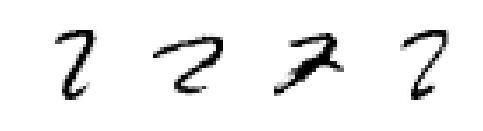

In [72]:

X = X_test[(y_test == 2) & (res == 7)][[0, 7, 8, 9]]

fig, axs = plt.subplots(figsize=(8, 5), ncols = 4)
for i in range(X.shape[0]):
    axs[i].imshow(X[i].reshape(-1, 28), cmap = 'Greys')
    axs[i].axis("off")

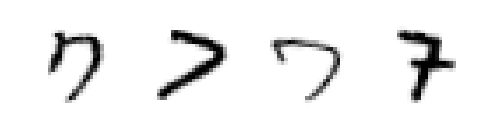

In [83]:

X  = X_train[(y_train == 7)][46:50]

fig, axs = plt.subplots(figsize=(8, 5), ncols = 4)
for i in range(X.shape[0]):
    z = transform.rotate(X[i].reshape(-1, 28), -10)
    axs[i].imshow(z, cmap = 'Greys')
    axs[i].axis("off")